https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

2024-05-20 17:11:19.031626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 17:11:19.031755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 17:11:19.171889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Total images: 4317
Image shape: (128, 128, 3)


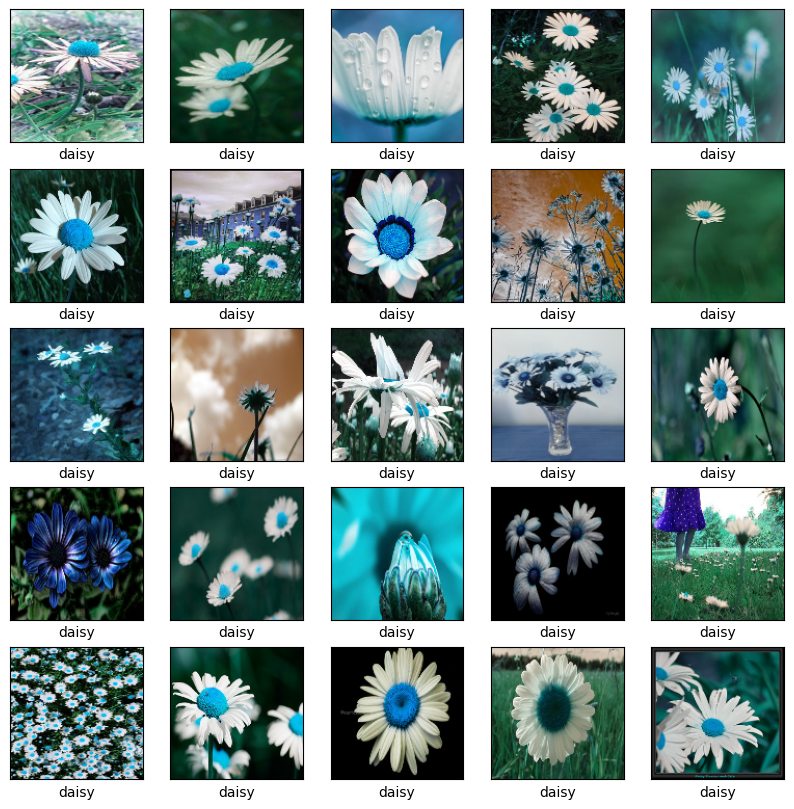

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
data_dir = '/kaggle/input/flowers-recognition/flowers'
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'
img_height, img_width = 128, 128

def load_data(data_dir, categories, img_height, img_width):
    images = []
    labels = []
    for idx, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            if img is not None and img.size > 0:  # Check if the image is not empty
                img = cv2.resize(img, (img_height, img_width))
                if img.dtype == np.uint8:  # Ensure image depth is 8-bit unsigned integer
                    images.append(img)
                    labels.append(idx)
                else:
                    print(f"Skipping image {img_name} due to incorrect depth: {img.dtype}")
            else:
                print(f"Skipping empty image: {img_path}")
    return np.array(images), np.array(labels)

images, labels = load_data(data_dir, categories, img_height, img_width)

print(f'Total images: {images.shape[0]}')
print(f'Image shape: {images.shape[1:]}')

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(categories[labels[i]])
plt.show()


In [ ]:
# First split: train (70%) and temp (30%)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels)

# Second split: validation (10%) and test (20%) from the temp set
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=2/3, random_state=42, stratify=temp_labels)

print(f'Train set: {train_images.shape[0]} images')
print(f'Validation set: {val_images.shape[0]} images')
print(f'Test set: {test_images.shape[0]} images')


Train set: 3021 images
Validation set: 432 images
Test set: 864 images


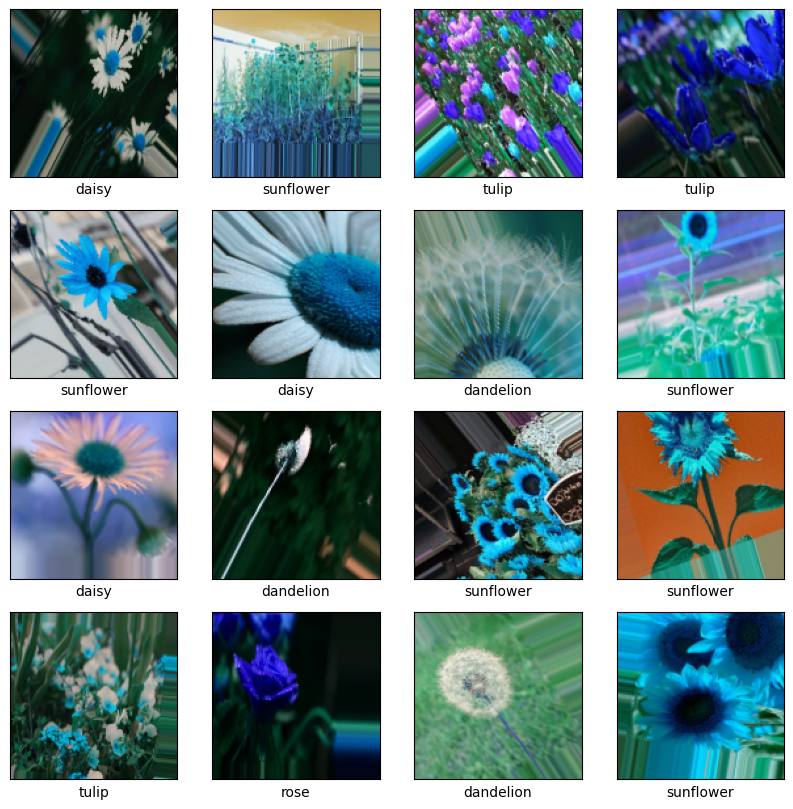

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)
augmented_images, augmented_labels = next(datagen.flow(train_images, train_labels, batch_size=16))

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(augmented_images[i].astype('uint8'))  # Ensure images are displayed correctly
    plt.xlabel(categories[augmented_labels[i]])
plt.show()

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
sift = cv2.SIFT_create()

def extract_sift_descriptors(img):
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

def extract_sift_features_parallel(images):
    descriptors_list = []
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(extract_sift_descriptors, img): img for img in images}
        for future in as_completed(futures):
            descriptors = future.result()
            if descriptors is not None:
                descriptors_list.append(descriptors)
    return descriptors_list

sift_descriptors = extract_sift_features_parallel(train_images)

if not sift_descriptors:
    print("No valid SIFT descriptors found. Exiting...")
else:
    # Construct visual vocabulary using k-means clustering
    num_clusters = 100
    all_descriptors = np.vstack(sift_descriptors)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)

    # Represent images as histograms of visual words
    def build_histograms(images, kmeans, num_clusters):
        histograms = []
        for img in images:
            if img is not None and img.size > 0 and img.dtype == np.uint8:
                keypoints, descriptors = sift.detectAndCompute(img, None)
                if descriptors is not None:
                    visual_words = kmeans.predict(descriptors)
                    histogram, _ = np.histogram(visual_words, bins=np.arange(0, num_clusters + 1))
                    histograms.append(histogram)
                else:
                    histograms.append(np.zeros(num_clusters))
        return np.array(histograms)

    train_features = build_histograms(train_images, kmeans, num_clusters)
    val_features = build_histograms(val_images, kmeans, num_clusters)
    test_features = build_histograms(test_images, kmeans, num_clusters)

    # Handle division by zero in normalization
    def normalize_histograms(histograms):
        sums = histograms.sum(axis=1, keepdims=True)
        sums[sums == 0] = 1
        return histograms / sums

    train_features = normalize_histograms(train_features)
    val_features = normalize_histograms(val_features)
    test_features = normalize_histograms(test_features)


    svc = SVC()
    svc.fit(train_features, train_labels)

    val_predictions = svc.predict(val_features)
    print(classification_report(val_labels, val_predictions))

    cm = confusion_matrix(val_labels, val_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(train_features, train_labels)

print(f"Best parameters: {grid.best_params_}")
val_predictions = grid.predict(val_features)
print(classification_report(val_labels, val_predictions))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.6s
[CV] END ........................C=0.1, gamma=1

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

img_height, img_width = 128, 128
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

In [ ]:

train_generator = datagen.flow_from_directory(
    directory='/kaggle/input/flowers-recognition/flowers',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    directory='/kaggle/input/flowers-recognition/flowers',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)


Found 3887 images belonging to 5 classes.
Found 430 images belonging to 5 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50  # Increase the number of epochs
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


121/121 ━━━━━━━━━━━━━━━━━━━━ 115s 909ms/step - accuracy: 0.3104 - loss: 3.7481 - val_accuracy: 0.2428 - val_loss: 2.2440
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - accuracy: 0.2500 - loss: 1.9191 - val_accuracy: 0.2857 - val_loss: 2.3984
Epoch 3/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


121/121 ━━━━━━━━━━━━━━━━━━━━ 140s 900ms/step - accuracy: 0.3380 - loss: 1.7290 - val_accuracy: 0.3077 - val_loss: 1.6044
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.4062 - loss: 1.4280 - val_accuracy: 0.1429 - val_loss: 1.6935
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 109s 885ms/step - accuracy: 0.3663 - loss: 1.5205 - val_accuracy: 0.3438 - val_loss: 1.5764
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.3125 - loss: 1.4266 - val_accuracy: 0.2857 - val_loss: 1.5243
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 138s 902ms/step - accuracy: 0.4010 - loss: 1.4521 - val_accuracy: 0.3726 - val_loss: 1.4359
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4375 - loss: 1.3458 - val_accuracy: 0.3571 - val_loss: 1.4313
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 139s 885ms/step - accuracy: 0.4418 - loss: 1.3958 - val_accuracy: 0.4736 - val_loss: 1.2810
Epoch 10/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.5312 - loss: 1.3756 - val_a

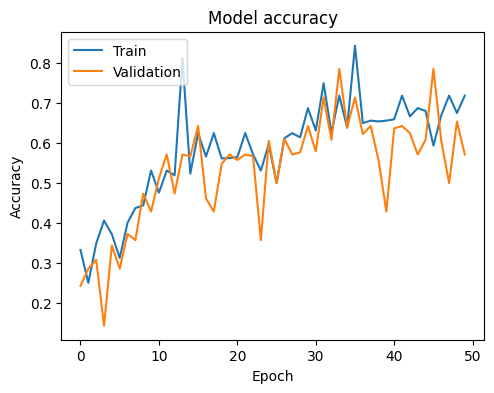

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

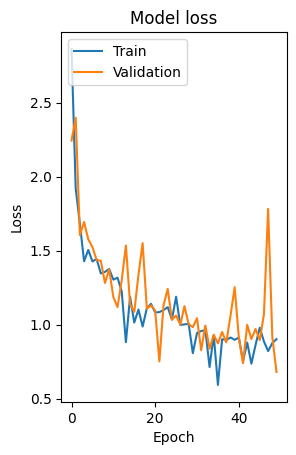

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc}')

27/27 - 5s - 170ms/step - accuracy: 0.4306 - loss: 140.9884
Test accuracy: 0.4305555522441864


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step
              precision    recall  f1-score   support

       daisy       0.28      0.81      0.42       152
   dandelion       0.62      0.44      0.51       211
        rose       0.54      0.21      0.30       157
   sunflower       0.55      0.56      0.56       147
       tulip       0.57      0.20      0.30       197

    accuracy                           0.43       864
   macro avg       0.51      0.45      0.42       864
weighted avg       0.52      0.43      0.42       864



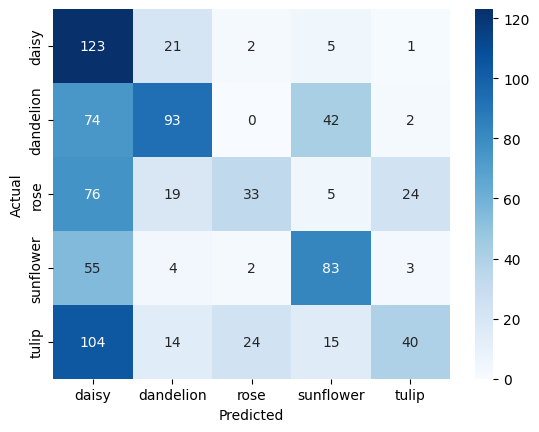

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_predictions = model.predict(test_images)
test_predictions = np.argmax(test_predictions, axis=1)

print(classification_report(test_labels, test_predictions, target_names=categories))

cm = confusion_matrix(test_labels, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Analyzing and Comparing
1. Comparison of Accuracy

    Model Accuracy for SVM: 54%
    CNN Model Reliability: 43%

In terms of overall accuracy, the SVM model outperforms the CNN model.
2. Performance by Class

Comparing each class's recall, precision, and F1-score:

Performance of the SVM Model:

    Daisy: F1-score 0.60, recall 0.49, precision 0.76
    Dandelion: F1-score 0.60, Precision 0.55, and Recall 0.68
    Rose: F1-score 0.50, recall 0.49, precision 0.52
    Sunflower: F1-score 0.52; precision 0.54; recall 0.51
    Tulip: F1-score 0.48, recall 0.51, precision 0.45

CNN Model Execution:

    Daisy: F1-score 0.42, recall 0.81, precision 0.28
    Dandelion: F1-score 0.51, Precision 0.62, and Recall 0.44
    Rose: F1-score 0.30, recall 0.21, precision 0.54
    Sunflower: F1-score 0.56, recall 0.56, and precision 0.55
    Tulip: F1-score 0.30, recall 0.20, precision 0.57
    
 3. Advantages and Disadvantages

    SVM using Word Bags:
        Advantages: Increased accuracy all around.
            greater overall performance in the majority of classes.
            less computationally demanding than deep learning.
        Weaknesses: Reliance on handcrafted features limits the ability to capture complicated patterns in data.
            Might need a lot of feature engineering and preprocessing.

    CNN's strengths include its ability to identify intricate patterns and features from unprocessed data.
            Possibility of improved performance with additional data and fine tuning.
            Does well in classes such as Sunflower and Dandelion.
        Drawbacks: This example has a lower overall accuracy.
            more computationally demanding, needing greater resources for inference and training.
            For best results, a larger dataset and more thorough adjustment are needed.

4. Efficiency in Computation

    SVM: More effective to train and execute overall, particularly on smaller datasets.
    CNN: Needs a lot of processing power and time, particularly when working with complicated models and big datasets.

5. Flexibility

    SVM: Works fairly well for basic issues and smaller datasets.
    CNN: Needs a lot of processing power, but it scales better with big datasets and can handle more intricate patterns.
    

6. Suitable Hybrid Approach

    Situation: It may be advantageous to combine SVM with CNN techniques in the following situations: First, features can be extracted using conventional techniques such as SIFT, and a CNN can be employed to further refine and categorize the data based on these features.
        Performance and efficiency can be balanced when computing resources are constrained by utilizing a smaller CNN for final classification and an SVM for initial processing.
        For applications where features need to be comprehensible and interpreted, the hybrid approach can be a favorable compromise.